In [1]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

# [NetworkX](https://networkx.org/)

* [most popular](https://pypistats.org/packages/networkx) graph analytics library
* easy-to-use API
* [documentation](https://networkx.org/documentation/stable/index.html) with examples
* **tradeoff** is performance





### **NVIDIA RAPIDS cuGraph** Backend

* NetworkX version >= 3 introduced backends
* nx-cugraph : GPU acceleration, unchanged API

In [2]:
!pip list | grep -E 'networkx|cugraph'

cugraph-cu12              24.12.0
networkx                  3.4.2
nx-cugraph-cu12           24.12.0
pylibcugraph-cu12         24.12.0


In [3]:
# If installation needed:
# !pip install -q matplotlib scipy
# !pip install -q --extra-index-url=https://pypi.nvidia.com "cudf-cu12==24.12.*" "cugraph-cu12==24.12.*" "nx-cugraph-cu12==24.12.*"

### Numuerous ways to configure NVIDIA RAPIDS cuGraph

In [4]:
# export NETWORKX_AUTOMATIC_BACKENDS=cugraph

# %set_env NETWORKX_AUTOMATIC_BACKENDS=cugraph

# nx.config.backend_priority=["cugraph"]  # NETWORKX_BACKEND_PRIORITY=cugraph

<br/>

---

# Graph 1 : [Zachary's Karate Club](https://en.wikipedia.org/wiki/Zachary%27s_karate_club)
* 34 nodes

### Use networkx version >= 3.4.*

In [5]:
import matplotlib.pyplot as plt

import networkx as nx

nx.__version__

'3.4.2'

In [6]:
G = nx.karate_club_graph()
G.number_of_nodes(), G.number_of_edges()

(34, 78)

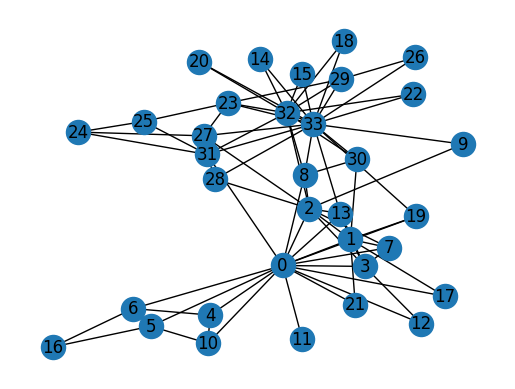

In [7]:
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos)
nx.draw_networkx_edges(G, pos)
nx.draw_networkx_labels(G, pos)
# plt.tight_layout()
plt.axis("off")
plt.show()

<br/>

---

# Algo 1 : [Betweenness Centrality](https://en.wikipedia.org/wiki/Betweenness_centrality)  

* for each node (`v`), count of shortest paths between node pairs that pass through `v`
* ie, count of connections between other nodes
* higher count equals higher centrality

In [8]:
nx_bc_results = nx.betweenness_centrality(G)

In [9]:
nx.set_node_attributes(G, nx_bc_results, "nx_bc")

In [10]:
nx_bc_results

{0: 0.43763528138528146,
 1: 0.053936688311688304,
 2: 0.14365680615680618,
 3: 0.011909271284271283,
 4: 0.0006313131313131313,
 5: 0.02998737373737374,
 6: 0.029987373737373736,
 7: 0.0,
 8: 0.05592682780182781,
 9: 0.0008477633477633478,
 10: 0.0006313131313131313,
 11: 0.0,
 12: 0.0,
 13: 0.04586339586339586,
 14: 0.0,
 15: 0.0,
 16: 0.0,
 17: 0.0,
 18: 0.0,
 19: 0.03247504810004811,
 20: 0.0,
 21: 0.0,
 22: 0.0,
 23: 0.017613636363636363,
 24: 0.0022095959595959595,
 25: 0.0038404882154882154,
 26: 0.0,
 27: 0.02233345358345358,
 28: 0.0017947330447330447,
 29: 0.0029220779220779218,
 30: 0.014411976911976909,
 31: 0.13827561327561325,
 32: 0.145247113997114,
 33: 0.30407497594997596}

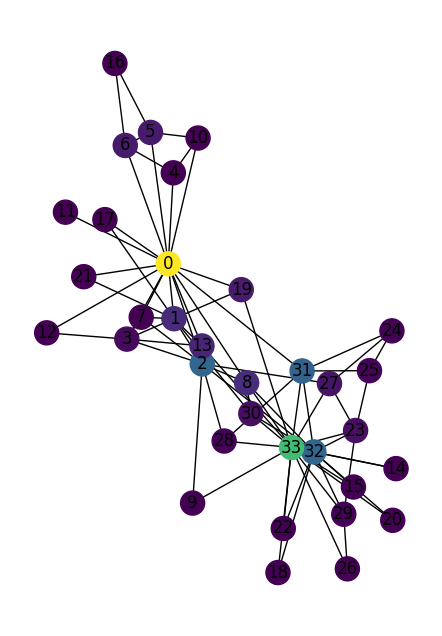

In [11]:
# Configure plot size and layout/position for each node
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 8]
pos = nx.spring_layout(G)

# Assign colors for each set of betweenness centrality results
nx_colors = [G.nodes[n]["nx_bc"] for n in G.nodes()]

# Plot the graph and color each node corresponding to NetworkX betweenness centrality values
plt.subplot(1, 2, 1)
nx.draw(G, pos=pos, with_labels=True, node_color=nx_colors)

* `0` and `33` are the most central
* followed by `2`, `31`, and `32`.

<br/>

---

# Algo 2 : [PageRank](https://en.wikipedia.org/wiki/PageRank) Link Analysis

In [12]:
nx_pr_results = nx.pagerank(G)

In [13]:
nx.set_node_attributes(G, nx_pr_results, "nx_pr")

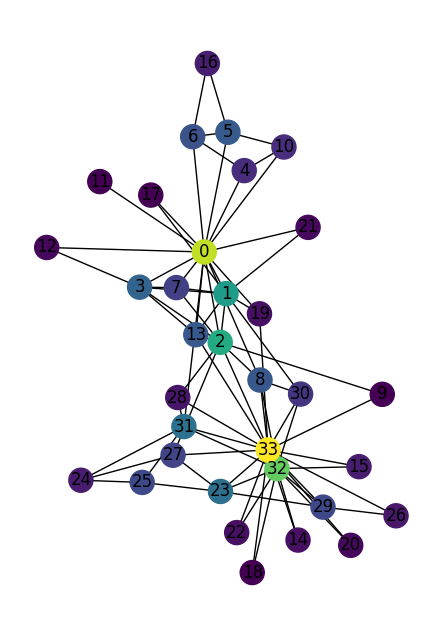

In [14]:
# Configure plot size and layout/position for each node
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 8]
pos = nx.spring_layout(G)

# Assign colors for each set of betweenness centrality results
nx_colors = [G.nodes[n]["nx_pr"] for n in G.nodes()]

# Plot the graph and color each node corresponding to NetworkX betweenness centrality values
plt.subplot(1, 2, 1)
nx.draw(G, pos=pos, with_labels=True, node_color=nx_colors)

<br/>

---
# Graph 2 : [US Patent Citations](https://snap.stanford.edu/data/cit-Patents.html) (16.5M / 3.8M)

In [15]:
# The locale encoding may have been modified from the plots above, reset here to run shell commands
# import locale
# locale.getpreferredencoding = lambda: "UTF-8"
!wget https://snap.stanford.edu/data/cit-Patents.txt.gz  # Skip if cit-Patents.txt.gz already exists.

--2025-02-03 16:58:34--  https://snap.stanford.edu/data/cit-Patents.txt.gz
171.64.75.80ap.stanford.edu (snap.stanford.edu)... 
connected. to snap.stanford.edu (snap.stanford.edu)|171.64.75.80|:443... 
HTTP request sent, awaiting response... 200 OK
Length: 85139832 (81M) [application/x-gzip]
Saving to: ‘cit-Patents.txt.gz.3’

cit-Patents.txt.gz. 100%[===================>]  81.20M  16.6MB/s    in 10s     

2025-02-03 16:58:45 (7.84 MB/s) - ‘cit-Patents.txt.gz.3’ saved [85139832/85139832]



<br/>

---
### **RAPIDS OFF** - load data

In [16]:
import pandas as pd
pd

<module 'pandas' from '/home/will/git/Accelerated_Data_Sci/venv/lib/python3.12/site-packages/pandas/__init__.py'>

In [17]:
%%time
# 5.94 - Colab

df = pd.read_csv("cit-Patents.txt.gz",
                 compression="gzip",
                 skiprows=4,
                 sep="\t",
                 names=["src", "dst"],
                 dtype="int32",
)

CPU times: user 1.4 s, sys: 69 ms, total: 1.47 s
Wall time: 1.47 s


---

### **RAPIDS ON** - load data

In [18]:
%load_ext cudf.pandas
import pandas as pd

In [19]:
%%time
# 1.51  X 3.9 SPEEDUP - Colab  (A100)

df = pd.read_csv("cit-Patents.txt.gz",
                 compression="gzip",
                 skiprows=4,
                 sep="\t",
                 names=["src", "dst"],
                 dtype="int32",
)

CPU times: user 551 ms, sys: 84 ms, total: 635 ms
Wall time: 631 ms


---
### Load Graph

In [20]:
%%time
!date
# 77 - Colab (RAPIDS OFF)
# 59 - Colab (A100)

G = nx.from_pandas_edgelist(df, source="src", target="dst")
G.number_of_nodes(), G.number_of_edges()

Mon Feb  3 04:59:02 PM EST 2025
CPU times: user 26.3 s, sys: 872 ms, total: 27.2 s
Wall time: 27.3 s


(3774768, 16518948)

In [21]:
len(
    set(
        list(df["src"].unique()) +
        list(df["dst"].unique())
        )
    )

3774768

In [22]:
df.sort_values(["src", "dst"]).head(3)

,src,dst
0,3858241,956203
1,3858241,1324234
2,3858241,3398406


<br/>

<br/>

<br/>

# **RAPIDS ON/OFF**

---
### Cache
* cache graph object in different structures

In [23]:
import warnings
warnings.filterwarnings("ignore")

nx.config.cache_converted_graphs=True   # NETWORKX_CACHE_CONVERTED_GRAPHS=True

<br/>

---
### **RAPIDS OFF** - betweenness & PageRank

In [24]:
# no accelerators
nx.config.backend_priority = []

### Betweeness Centrality

In [25]:
%%time
!date
# 93 - Colab

bc_results = nx.betweenness_centrality(G, k=1)

Mon Feb  3 04:59:32 PM EST 2025
CPU times: user 29 s, sys: 702 ms, total: 29.7 s
Wall time: 29.8 s


### PageRank

In [26]:
%%time
!date
# 154 - Colab

nx_pr_results = nx.pagerank(G)

Mon Feb  3 05:00:02 PM EST 2025
CPU times: user 21.2 s, sys: 1.58 s, total: 22.8 s
Wall time: 22.9 s


---
### **RAPIDS ON** - betweenness & PageRank

In [27]:
# export NETWORKX_AUTOMATIC_BACKENDS=cugraph
nx.config.backend_priority=["cugraph"]  # NETWORKX_BACKEND_PRIORITY=cugraph

### Betweenness Centrality

In [28]:
%%time
# 22.5   X 4   SPEEDUP - Colab (A100)
!date

# k sampling; accuracy tradeoff
bc_results_cu = nx.betweenness_centrality(G, k=1)

Fri Jan 31 06:13:56 PM UTC 2025
CPU times: user 20.2 s, sys: 1.03 s, total: 21.2 s
Wall time: 22.5 s


In [29]:
%%time
# 1.31 X 72 SPEEDUP - Colab (A100)
!date

# k sampling; accuracy tradeoff
bc_results_cu = nx.betweenness_centrality(G, k=1)

Fri Jan 31 06:14:18 PM UTC 2025
CPU times: user 933 ms, sys: 282 ms, total: 1.22 s
Wall time: 1.31 s


### PageRank

In [30]:
%%time
!date
# 27.6  X 5.5 SPEEDUP - Colab (A100)
nxcg_pr_results = nx.pagerank(G, backend="cugraph")

Fri Jan 31 06:14:20 PM UTC 2025
CPU times: user 26.6 s, sys: 1.06 s, total: 27.6 s
Wall time: 27.6 s


In [31]:
%%time
!date
# 1.29 X 71 SPEEDUP - Colab (A100)
nxcg_pr_results = nx.pagerank(G, backend="cugraph")

Fri Jan 31 06:14:47 PM UTC 2025
CPU times: user 910 ms, sys: 291 ms, total: 1.2 s
Wall time: 1.29 s


### k = n

In [32]:
%%time
!date
# 5.31  - Colab (A100)

bc_results_cu_k1000 = nx.betweenness_centrality(G, k=100)

Fri Jan 31 06:14:49 PM UTC 2025
CPU times: user 4.92 s, sys: 518 ms, total: 5.44 s
Wall time: 5.31 s


<br/>

---
<i>
Each user is responsible for checking the content of datasets and the applicable licenses and determining if suitable for the intended use.
<i>
<br>
<br>
<i>
Information on the U.S. Patent Citation Network dataset used in this notebook is as follows:
<br>Authors: Jure Leskovec and Andrej Krevl
<br>Title: SNAP Datasets, Stanford Large Network Dataset Collection
<br>URL: http://snap.stanford.edu/data
<br>Date: June 2014
</i>
